# Stage 2: Full Pipeline with Linear Model

# 1. Preprocessing 

## 1.1 Loading the data

In [1]:
# Imports
import os
import time
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm 
import shutil
from data.util import *
from data.transformer import *
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import RFE,RFECV #importing RFE class from sklearn library
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import validation_curve
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import SelectKBest,chi2

In [4]:
# load training and testing data into memory
root_path = "data"
X_train, s_train, y_train_str, p_train, i_train = TrainDataLoader(root_path).load()
X_test = TestDataLoader(root_path).load()
X_train, s_train, y_train_str, p_train, i_train = TrainDataLoader(root_path).load()

# X_train: all features (pixels x 3) of all training samples (4146)
# s_train: superclasses of all samples (4146); note ordered
# y_train: classes of all samples (4146); note ordered
# p_train: pole IDs of all samples (4146)
# i_train: indices of all samples (4146); note duplicates
# X_test: all features (pixels x 3) of all testing samples (4293)

# Make sure that you properly encode the CLASSES such that 
# the order in your submission files is correct!
label_enc = LabelEncoder()
label_enc.fit(CLASSES)
y_train = label_enc.transform(y_train_str) # numerical labels
    
# Randomizer
numpy_seed = 0
python_seed = 0
np.random.seed(numpy_seed)
random.seed(python_seed)

In [5]:
# display some numbers
number_of_train_samples = len(X_train)
number_of_classes = len(np.unique(y_train))
number_of_test_samples = len(X_test)
print('number of training samples:', number_of_train_samples)
print('number of testing samples:', number_of_test_samples)
print('number of labels:', number_of_classes)

number of training samples: 4146
number of testing samples: 4293
number of labels: 81


## 1.2 Class distribution

FileNotFoundError: [Errno 2] No such file or directory: 'visualization\\class_distribution.png'

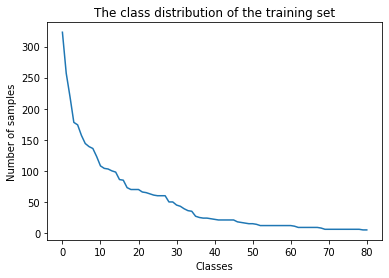

In [6]:
# Create a plot showing the class distribution in the training set
fig_distr, ax_distr = plt.subplots()
ax_distr.set_title("The class distribution of the training set")
ax_distr.set_xlabel("Classes")
ax_distr.set_ylabel("Number of samples")

count = countOcc(y_train)
plt.plot([i for i in range(len(count))], count);
fig_distr.savefig(os.path.join('visualization','class_distribution.png'))

## 1.4 Resize all images to a fixed resolution

(4146, 64, 64, 3)
(4293, 64, 64, 3)


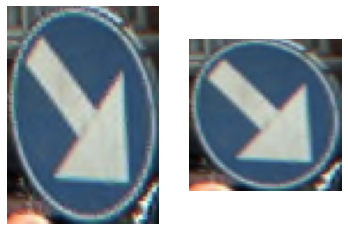

In [7]:
X_train_resized = ResizeTransformer().transform(X_train)
X_test_resized = ResizeTransformer().transform(X_test)
print(X_train_resized.shape)
print(X_test_resized.shape)

# Show effect of resizing
image_index = 99
image_ori = Image.fromarray(X_train[image_index])
image_res = Image.fromarray(X_train_resized[image_index])
# create figure and show images
fig_res, ax_res = plt.subplots(1,2)
ax_res[0].imshow(image_ori)
ax_res[1].imshow(image_res)
ax_res[0].set_axis_off()
ax_res[1].set_axis_off()


# 3. Feature Visualization

## 3.1 Histogram for 1 feature
A histogram that plots the number of samples with certain HOG values for 1 specific HOG feature.

In [ ]:
# Visualize the histogram for a specific feature
feature_index = 9
feature = X_train_hog[:,feature_index]
fig_feat, ax_feat = plt.subplots()
ax_feat.set_title("Histogram for feature {}".format(feature_index))
ax_feat.set_xlabel("HOG values")
ax_feat.set_ylabel("number of samples")
plot_histogram(ax_feat, feature, bins=50)

## 3.2 Histogram for 1 sample
A histogram that plots the number of features with certain HOG values for 1 specific sample. There's also a function implemented to plot histograms for multiple samples. This is to visually check for correlations between samples and try to understand what the poleIDs and IDs play as roles in the dataset.
Note that samples with different poleIDs but identical IDs have (visually) identical histograms. This implies a correlation between these samples.

In [ ]:
# Visualize the histogram for a specific sample
sample_index = 99
sample = X_train_hog[sample_index,:]
image = Image.fromarray(X_train[sample_index])
#image.show() # uncomment to show corresponding images
fig_samp, ax_samp = plt.subplots()
ax_samp.set_title("Histogram for sample {}".format(sample_index))
ax_samp.set_xlabel("HOG values")
ax_samp.set_ylabel("number of features")
plot_histogram(ax_samp, sample, bins=50)
fig_im, ax_im = plt.subplots()
ax_im.imshow(image)
ax_im.set_axis_off()

# Aspect Ratio Features

In [ ]:
aspect_ratio = [get_ratio(img) for img in X_train]

plt.ylim(0,5)
plt.xlabel("Class index")
plt.ylabel("Aspect Ratio")
plt.title("Distribution of aspect ratio among training samples.")
plt.scatter(y_train, aspect_ratio, alpha=0.42, s=1)

## 3.4. Cross-Validation Strategy --Group split

In [8]:
# cross validation strategy -- stratified and grouped
cv_indices = []
folds = 5
sgkf = stratified_group_k_fold(X_train, y_train, p_train, k=folds)
for train_fold, test_fold in sgkf:
    cv_indices.append((train_fold, test_fold))

## 4.1 Tuned model
Tuning of the hyperparameters happens here. Before we can start doing this, we should first evaluate the model using the train-CV and CV-test gaps as well as the learning curves. 

Dimensionality Reduction
1. Select kbest
2. Recursive Feature Elimination
3. LDA

In [10]:
rfe = RFE(estimator=LogisticRegression(max_iter=1000, n_jobs=-2), n_features_to_select=1000,step=50)
pipeline_select_hog = Pipeline([('resize', ResizeTransformer()),
                                ('hog', HogTransformer()),
                                ('kBest',SelectKBest(chi2,k=3000)),
                                ('recursive',rfe)
                               ])
pipeline_select_colorhist = Pipeline([('select_colorhist', colorhistTransformer())])
pipeline_aspect_ratio = Pipeline([('aspect_ratio', AspectRatioTransformer())])

pipeline_select_features = FeatureUnion([('hog_select',pipeline_select_hog),('color_select',pipeline_select_colorhist),
                                        ('REST', pipeline_aspect_ratio)])

pipeline = Pipeline([('features',pipeline_select_features),
                    ('scalar', StandardScaler()),
                    ('logreg', LogisticRegression(max_iter=1000, n_jobs=-2))
                    ])

# show all available parameters
print(pipeline.get_params())


# # tuned parameters
# # lr_weights = ['balanced', None]
# # boolean = [True, False]

resize_range = [64] # use this with hog__resize : [True]
hog__blockSize = [32]
hog__blockStride=[2]
hog__cellSize = [8]
hog__winSize = [32]
hog__nbins = [15]
nbin = [4]
k_features = [3000]
rfe_features = [1000]
# lr_C = [0.01, 0.1, 1, 10]
lr_C = [1]

param_grid = {'features__hog_select__resize__size':resize_range,
              'features__hog_select__hog__blockSize':hog__blockSize,
              'features__hog_select__hog__blockStride':hog__blockStride,
              'features__hog_select__hog__cellSize':hog__cellSize,
              'features__hog_select__hog__winSize':hog__winSize,
              'features__hog_select__hog__nbins':hog__nbins,
              'features__color_select__select_colorhist__nbin':nbin,
              'features__hog_select__kBest__k':k_features,
              'features__hog_select__recursive__n_features_to_select':rfe_features,
              'logreg__C':lr_C}
# perform grid search
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=cv_indices, 
                            scoring=neg_logloss_scorer, verbose=True, 
                            n_jobs=-2, return_train_score=True)
grid_search.fit(X_train, y_train, groups=p_train)
show_grid_scores(grid_search)
estimator = get_best_model(grid_search)



{'memory': None, 'steps': [('features', FeatureUnion(transformer_list=[('hog_select',
                                Pipeline(steps=[('resize', ResizeTransformer()),
                                                ('hog', HogTransformer()),
                                                ('kBest',
                                                 SelectKBest(k=3000,
                                                             score_func=<function chi2 at 0x000001D14F3B6AE8>)),
                                                ('recursive',
                                                 RFE(estimator=LogisticRegression(max_iter=1000,
                                                                                  n_jobs=-2),
                                                     n_features_to_select=1000,
                                                     step=50))])),
                               ('color_select',
                                Pipeline(steps=[('select_colorhist',
 

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed: 40.4min finished


Grid scores on training data set:
-0.173 (+/-0.131) for {'features__color_select__select_colorhist__nbin': 4, 'features__hog_select__hog__blockSize': 32, 'features__hog_select__hog__blockStride': 2, 'features__hog_select__hog__cellSize': 8, 'features__hog_select__hog__nbins': 15, 'features__hog_select__hog__winSize': 32, 'features__hog_select__kBest__k': 3000, 'features__hog_select__recursive__n_features_to_select': 1000, 'features__hog_select__resize__size': 64, 'logreg__C': 1}
Best parameters set found on development set:  {'features__color_select__select_colorhist__nbin': 4, 'features__hog_select__hog__blockSize': 32, 'features__hog_select__hog__blockStride': 2, 'features__hog_select__hog__cellSize': 8, 'features__hog_select__hog__nbins': 15, 'features__hog_select__hog__winSize': 32, 'features__hog_select__kBest__k': 3000, 'features__hog_select__recursive__n_features_to_select': 1000, 'features__hog_select__resize__size': 64, 'logreg__C': 1}

Obtained pipeline:
Pipeline(steps=[('fea

NameError: name 'Xtrain' is not defined

In [27]:
print(estimator)
X_train_tu=estimator.fit_transform(X_train,y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('hog_select',
                                                 Pipeline(steps=[('resize',
                                                                  ResizeTransformer()),
                                                                 ('hog',
                                                                  HogTransformer(blockSize=32,
                                                                                 blockStride=2,
                                                                                 nbins=15,
                                                                                 winSize=32)),
                                                                 ('kBest',
                                                                  SelectKBest(k=3000,
                                                                              score_func=<function chi2 at 0x000001D14F3B6AE8>)),
   

AttributeError: 'LogisticRegression' object has no attribute 'transform'

# Tuned parameters based on linear model

In [20]:
# Resizing
X_train_resized=ResizeTransformer(size=64).transform(X_train)
X_test_resized=ResizeTransformer(size=64).transform(X_test)

# hog features
X_train_hog = HogTransformer(winSize=32, blockSize=32, blockStride=2, cellSize=8, nbins=15).transform(X_train_resized)
X_test_hog = HogTransformer(winSize=32, blockSize=32, blockStride=2, cellSize=8, nbins=15).transform(X_test_resized)

# select Kbest
selector = SelectKBest(chi2, k=3000)
X_train_hog_Kbest=selector.fit_transform(X_train_hog, y_train)
X_test_hog_Kbest=selector.transform(X_test_hog)

# select rfe
rfe = RFE(estimator=LogisticRegression(max_iter=1000, n_jobs=-2), n_features_to_select=1000,step=50)
X_train_hog_Kbest_rfe = rfe.fit_transform(X_train_hog_Kbest,y_train)
X_test_hog_Kbest_rfe = rfe.transform(X_test_hog_Kbest)

# color features
X_train_color = colorhistTransformer(nbin=4).transform(X_train)
X_test_color = colorhistTransformer(nbin=4).transform(X_test)

# Aspect ratio features
X_train_aspect = AspectRatioTransformer().transform(X_train)
X_test_aspect = AspectRatioTransformer().transform(X_test)

# Combined features
X_train_tuned = np.concatenate((X_train_hog_Kbest_rfe, X_train_color,X_train_aspect), axis=1)
X_test_tuned = np.concatenate((X_test_hog_Kbest_rfe, X_test_color,X_test_aspect), axis=1)

print(np.shape(X_test_tuned))

NameError: name 'X_train_hog_Kbest_rfet' is not defined

# Linear Tuned Model

In [28]:
pipeline = Pipeline([('scalar', StandardScaler()),
                    ('logreg', LogisticRegression(max_iter=1000, n_jobs=-2))
                    ])

# show all available parameters
print(pipeline.get_params())


# # tuned parameters
# lr_C = [0.01, 0.1, 1, 10]
lr_C = [1]

param_grid = {'logreg__C':lr_C}


# perform grid search
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=cv_indices, 
                            scoring=neg_logloss_scorer, verbose=True, 
                            n_jobs=-2, return_train_score=True)
grid_search.fit(X_train_tuned, y_train, groups=p_train)
show_grid_scores(grid_search)

# get best model and calculate score
# estimator = get_best_model(grid_search)
# scores = cross_validate(estimator, X_train, y_train, groups=p_train, 
#                         cv=cv_indices, scoring=neg_logloss_scorer, return_train_score=True)
# show_scores(scores)

{'memory': None, 'steps': [('scalar', StandardScaler()), ('logreg', LogisticRegression(max_iter=1000, n_jobs=-2))], 'verbose': False, 'scalar': StandardScaler(), 'logreg': LogisticRegression(max_iter=1000, n_jobs=-2), 'scalar__copy': True, 'scalar__with_mean': True, 'scalar__with_std': True, 'logreg__C': 1.0, 'logreg__class_weight': None, 'logreg__dual': False, 'logreg__fit_intercept': True, 'logreg__intercept_scaling': 1, 'logreg__l1_ratio': None, 'logreg__max_iter': 1000, 'logreg__multi_class': 'auto', 'logreg__n_jobs': -2, 'logreg__penalty': 'l2', 'logreg__random_state': None, 'logreg__solver': 'lbfgs', 'logreg__tol': 0.0001, 'logreg__verbose': 0, 'logreg__warm_start': False}
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed:   54.6s finished


Grid scores on training data set:
-0.156 (+/-0.121) for {'logreg__C': 1}
Best parameters set found on development set:  {'logreg__C': 1}



# Non-linear Model

# Learning Curve

In [ ]:
# calculate and plot learning curve
estimator = get_best_model(grid_search)
# print(estimator)
learn_curv = learning_curve(estimator, X_train, y_train, train_sizes=np.linspace(.1, 1.0, 5),
                                cv=cv_indices, groups=p_train, scoring=neg_logloss_scorer, 
                                    n_jobs=-2, shuffle=True)
plot_learning_curve(learn_curv)

## 5.3. Confusion Matrix

In [ ]:
# plot confusion matrix and corresponding misclassified images for a certain fold
show_misclassifications(estimator, X_train, y_train, cv_indices, fold_number=1, N=20)

In [ ]:
numpy_classes=np.array(CLASSES)
print(np.concatenate((numpy_classes[y_true[y_pred!=y_true].astype(int)].reshape(-1,1),numpy_classes[y_pred[y_pred!=y_true].astype(int)].reshape(-1,1)),axis=1))

# 6. Submission

In [ ]:
# train best model using all training data
estimator.fit(X_train, y_train)
# Here is where we create the submission for your estimator
output_probabilities = estimator.predict_proba(X_test)
create_submission(output_probabilities, 'submission.csv')